## Алгоритмы анализа данных

#### Урок 2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск

In [ ]:
#Задание 1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного
#спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов
#на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
#Импортируем основные библиотеки
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14,
                     'xtick.labelsize': 14})

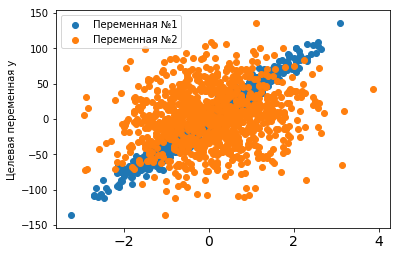

In [17]:
#Генерируем игрушечный датасет для решения задачи линейной регрессии методом градиентного спуска и стохастического
#градиентного спуска: уже сейчас по картинке можно видеть, что 1-ая переменная более значима по сравнению со 2-ой. Обе переменные
#имеют один масштаб и примерно одинаковый размах данных. Масштабировать признаки методом нормализации или стандартизации для 
#корректного сравнения величины их влияния на целевую переменную не дадут значительных изменений в весах. Увидим это позже 
#на картинках.
from sklearn import datasets

X_, y_, coef = datasets.make_regression(n_samples=1000, 
                                      n_features=2, 
                                      n_informative=2, 
                                      n_targets=1,
                                      noise=5, 
                                      coef=True, 
                                      random_state=42)
plt.scatter(X_[:,0], y_ , label = 'Переменная №1')
plt.scatter(X_[:,1], y_, label = 'Переменная №2')
plt.ylabel('Целевая переменная y')
plt.legend()

In [18]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

# Метод градиентного спуска, w - начальное приближение весов
def eval_GD(X, y, iterations, w_start, eta=1e-2):
    mse_gd = []
    np.random.seed(42)
    n = X.shape[0]
    w = w_start
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)))
        mse_gd.append(err)
    return mse_gd

# Метод стохастического градиентного спуска, w - начальное приближение весов
def eval_SGD(X, y, iterations, w_start, eta=1e-2):
    mse_sgd = []
    np.random.seed(42)
    n = X.shape[0] # число наблюдений
    w = w_start
    for i in range(1, iterations + 1):
        err = calc_mse(y, np.dot(X, w))
        # генерируем случайный индекс объекта выборки
        ind = np.random.randint(n)
        y_pred = np.dot(X[ind], w)
        mse_sgd.append(err)
        w -= eta * (2 * np.dot(X[ind].T, (y_pred - y[ind])))
    return mse_sgd

Text(0,0.5,'Среднеквадратичная ошибка прогноза')

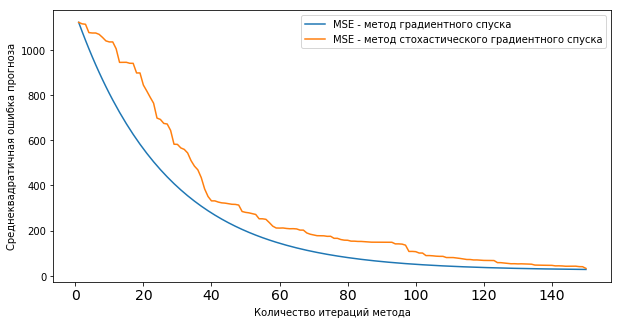

In [19]:
#Видим, что количество итераций для достижения целевого минимума mse и для метода градиентного спуска и для метода стохатического
#градиентного спуска требуется примерно одинаковое - около 150 итераций при старте из точки w = [7.0,  1.0],
#но количество необходимых вычислений для достижения этого минимума в случае стохастического спуска гораздо меньше. Скорость
#вычисления может быть важна при решении задач с большими данными.
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,151),eval_GD(X_, y_ , 150, [7.0,  1.0]), label = 'MSE - метод градиентного спуска' )
plt.plot(np.arange(1,151),eval_SGD(X_, y_, 150, [7.0,  1.0]), label = 'MSE - метод стохастического градиентного спуска' )
plt.legend()
plt.xlabel('Количество итераций метода')
plt.ylabel('Среднеквадратичная ошибка прогноза')

Text(0,0.5,'Среднеквадратичная ошибка прогноза')

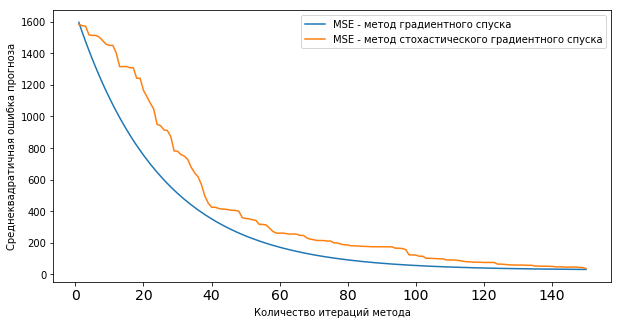

In [20]:
#Попробуем сделать тоже самое, переведя все признаковые описания объектов к нормальному распределению: значимых
#изменений не произошло - все верно, потому что нормализация не влияет на значение предсказанной целевой переменной.
X_st = X_.copy().astype(np.float64)
X_st[:, 1] = (X_[:, 1] - X_[:, 1].mean()) / X_[:, 1].std()
X_st[:, 0] = (X_[:, 0] - X_[:, 0].mean()) / X_[:, 0].std()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,151),eval_GD(X_st, y_ , 150, np.random.randn(X_st.shape[1])), label = 'MSE - метод градиентного спуска' )
plt.plot(np.arange(1,151),eval_SGD(X_st, y_, 150, np.random.randn(X_st.shape[1])), label = 'MSE - метод стохастического градиентного спуска' )
plt.legend()
plt.xlabel('Количество итераций метода')
plt.ylabel('Среднеквадратичная ошибка прогноза')

In [21]:
#Задание 2: добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на
#величину весов для примера из урока (лучше графически).


#Посмотрим влияние регуляризации L1 на mse:
def eval_model_reg1(X, y, iterations, eta = 1e-2, lambda_ = 0.5, verbose=False):
    np.random.seed(42)
    mse_sgd_reg1 = []
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        mse_sgd_reg1.append(err)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * np.sign(w))
    return mse_sgd_reg1

#Посмотрим влияние регуляризации L2 на mse:
def eval_model_reg2(X, y, iterations, eta=1e-2, lambda_=0.5, verbose=False):
    np.random.seed(42)
    mse_sgd_reg2 = []
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        mse_sgd_reg2.append(err)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * w)
    return mse_sgd_reg2

Text(0,0.5,'Среднеквадратичная ошибка прогноза')

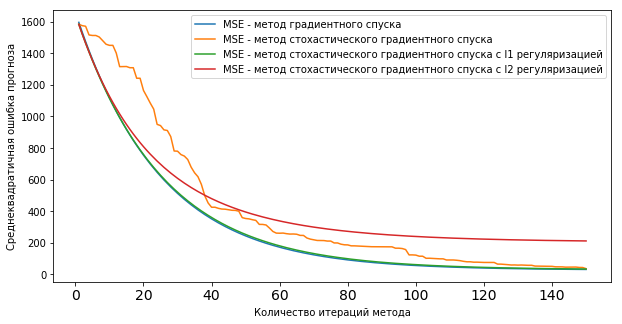

In [22]:
#Регуляризация увеличивает среднеквадратичную ошибку прогноза, оказывая влияние на веса. Самая большая среднеквадратичная
#ошибка прогноза получается при регуляризации L2 при количестве итераций = 150. На веса при регуляризации L2 оказывается бОльшее
#влияние, чем при регуляризации l1, направленой на "обнуление" весов наименее значимых признаков.

plt.figure(figsize=(10, 5))
plt.plot(np.arange(1,151),eval_GD(X_st, y_ , 150, np.random.randn(X_st.shape[1])), label = 'MSE - метод градиентного спуска' )
plt.plot(np.arange(1,151),eval_SGD(X_st, y_, 150, np.random.randn(X_st.shape[1])), label = 'MSE - метод стохастического градиентного спуска' )
plt.plot(np.arange(1,151),eval_model_reg1(X_st, y_, 150), label = 'MSE - метод стохастического градиентного спуска c l1 регуляризацией' )
plt.plot(np.arange(1,151),eval_model_reg2(X_st, y_, 150), label = 'MSE - метод стохастического градиентного спуска c l2 регуляризацией' )

plt.legend()
plt.xlabel('Количество итераций метода')
plt.ylabel('Среднеквадратичная ошибка прогноза')

In [23]:
#Посмотрим, как изменяется значение весов признаков с каждой итерацией: 
def eval_model_reg2(X, y, iterations, eta, lambda_, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * w)
    return w


def eval_model_reg1(X, y, iterations, eta, lambda_, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= eta * (1/n * 2 * np.dot(X.T, (y_pred - y)) + 2 * lambda_ * np.sign(w))
    return w

In [24]:
l_list = []

w_list_1 = []
error_list_1 = []

w_list_2 = []
error_list_2 = []

for l in np.logspace(start=-4, stop=1, num=20):
    l_list.append(l)
    w_new_1 = eval_model_reg1(X_st, y_, iterations=1000, eta=1e-2, lambda_=l)
    w_new_2 = eval_model_reg2(X_st, y_, iterations=1000, eta=1e-2, lambda_=l)
    w_list_1.append(w_new_1)
    w_list_2.append(w_new_2)
    error_list_1.append(calc_mse(y_, np.dot(X_st, w_new_1)))
    error_list_2.append(calc_mse(y_, np.dot(X_st, w_new_2)))
weights_1 = np.array(w_list_1)
errors_1 = np.array(error_list_1)

weights_2 = np.array(w_list_2)
errors_2 = np.array(error_list_2)

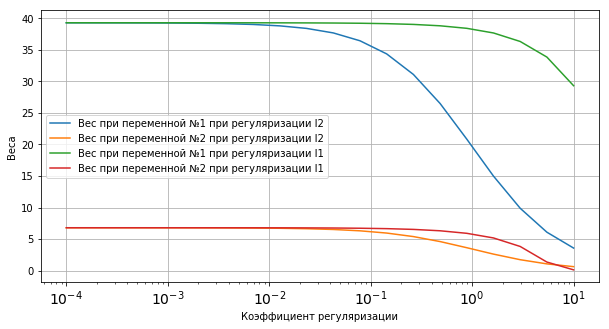

In [25]:
#Видим,что:
#1. чем больше коэффициент регуляризации, тем больше уменьшается вес признаков
#2. вес наименее значимой переменной стремится к нулю при увеличении коэффициента регуляризации

plt.figure(figsize=(10, 5))
plt.xscale('log')

plt.plot(l_list, weights_2[:, 0], label = 'Вес при переменной №1 при регуляризации l2')
plt.plot(l_list, weights_2[:, 1], label = 'Вес при переменной №2 при регуляризации l2')
plt.plot(l_list, weights_1[:, 0], label = 'Вес при переменной №1 при регуляризации l1')
plt.plot(l_list, weights_1[:, 1], label = 'Вес при переменной №2 при регуляризации l1')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Веса')
plt.grid()
plt.legend()